In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stats
import numpy as np

In [32]:
### EDA video_games_sales.csv ###
df_video_games = pd.read_csv('Data/video_games_sales.csv')
print("Primeras filas del dataset")
print(df_video_games.head(10))



Primeras filas del dataset
   Rank                       Name Platform    Year         Genre Publisher  \
0     1                 Wii Sports      Wii  2006.0        Sports  Nintendo   
1     2          Super Mario Bros.      NES  1985.0      Platform  Nintendo   
2     3             Mario Kart Wii      Wii  2008.0        Racing  Nintendo   
3     4          Wii Sports Resort      Wii  2009.0        Sports  Nintendo   
4     5   Pokemon Red/Pokemon Blue       GB  1996.0  Role-Playing  Nintendo   
5     6                     Tetris       GB  1989.0        Puzzle  Nintendo   
6     7      New Super Mario Bros.       DS  2006.0      Platform  Nintendo   
7     8                   Wii Play      Wii  2006.0          Misc  Nintendo   
8     9  New Super Mario Bros. Wii      Wii  2009.0      Platform  Nintendo   
9    10                  Duck Hunt      NES  1984.0       Shooter  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  
0     41.49     29.02      3.77         8.

In [33]:
print("\nDimensiones del dataset:")
print(f"Filas: {df_video_games.shape[0]}, Columnas: {df_video_games.shape[1]}")


Dimensiones del dataset:
Filas: 16598, Columnas: 11


In [34]:
print("\nValores nulos por columna:")
print(df_video_games.isnull().sum())


Valores nulos por columna:
Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64


In [35]:
## limpieza de video_games_sales.csv --> video_game_sales_limpio ##
df_video_games1 = df_video_games.drop_duplicates()
df_video_games2 = df_video_games1.dropna(subset=['Year', 'Publisher'])
df_video_games_limpio = df_video_games2[df_video_games2['Global_Sales'] > 0]
df_video_games_limpio['Year'] = df_video_games_limpio['Year'].astype(int)

In [36]:
print(f"Filas: {df_video_games_limpio.shape[0]}, Columnas: {df_video_games_limpio.shape[1]}")
print(df_video_games_limpio.dtypes)

Filas: 16291, Columnas: 11
Rank              int64
Name             object
Platform         object
Year              int64
Genre            object
Publisher        object
NA_Sales        float64
EU_Sales        float64
JP_Sales        float64
Other_Sales     float64
Global_Sales    float64
dtype: object


In [37]:
df_video_games_limpio.to_csv('Data/video_games_sales_limpio.csv', index=False)

In [38]:
#### categorización de ventas ####
q90 = df_video_games_limpio['Global_Sales'].quantile(0.90)
q70 = df_video_games_limpio['Global_Sales'].quantile(0.70)
q40 = df_video_games_limpio['Global_Sales'].quantile(0.40)
def clasificar_ventas(ventas):
    if ventas >= q90:
        return 'Gran Éxito'
    elif ventas >= q70:
        return 'Alta'
    elif ventas >= q40:
        return 'Media'
    else:
        return 'Baja'
 ## incluir nueva columna ###   
df_video_games_limpio['Ventas_Clase'] = df_video_games_limpio['Global_Sales'].apply(clasificar_ventas)
df_video_games_limpio.to_csv('Data/video_games_sales_limpio.csv', index=False)

In [39]:
## Union de video_games_ sales_ limpio y all_video_games(cleaned).csv ##
df_all_games = pd.read_csv('Data/all_video_games(cleaned).csv')

In [40]:
df_video_games_limpio['Title'] = df_video_games_limpio['Name'].str.strip().str.lower()
df_all_games['Title'] = df_all_games['Title'].str.strip().str.lower()
df_all_games_limpio = df_all_games[['Title', 'Product Rating', 'User Score', 'User Ratings Count', 'Platforms Info']]

In [41]:
df_video_games_unido = pd.merge(df_video_games_limpio, df_all_games_limpio, on='Title', how='left')

In [42]:
print(df_video_games_unido['Ventas_Clase'].value_counts())

Ventas_Clase
Baja          6477
Media         4916
Alta          3265
Gran Éxito    1633
Name: count, dtype: int64


In [43]:
# eliminamos columnas inneecesarias ## 
df_video_games_unido.drop(columns=['Rank','Title'], inplace=True) ## dudas de meter plataformas info y user_rating_score ##

In [44]:
#eliminacion de consolas con menos de 20 filas registradas #
platform_counts = df_video_games_unido['Platform'].value_counts()
platforms_to_remove = platform_counts[platform_counts < 20].index.tolist()
df_video_games_unido = df_video_games_unido[~df_video_games_unido['Platform'].isin(platforms_to_remove)].copy()


In [45]:
#renombramos la columna platform ##
# Diccionario de reemplazo de nombres de plataformas
platform_rename = {
    '2600': 'Atari 2600',
    'DS': 'Nintendo DS',
    'GB': 'Game Boy',
    'GBA': 'Game Boy Advance',
    'GC': 'GameCube',
    'GEN': 'Sega Genesis',
    'N64': 'Nintendo 64',
    'NES': 'Nintendo Entertainment System',
    'PC': 'PC',
    'PS': 'PlayStation',
    'PS2': 'PlayStation 2',
    'PS3': 'PlayStation 3',
    'PS4': 'PlayStation 4',
    'PSP': 'PlayStation Portable',
    'PSV': 'PlayStation Vita',
    'SAT': 'Sega Saturn',
    'SNES': 'Super Nintendo Entertainment System',
    'Wii': 'Nintendo Wii',
    'WiiU': 'Nintendo Wii U',
    'X360': 'Xbox 360',
    'XB': 'Xbox',
    'XOne': 'Xbox One',
    'DC': 'Dream Cast',
    '3DS': 'Nintendo 3DS',
}

# Reemplazar los nombres
df_video_games_unido['Platform'] = df_video_games_unido['Platform'].replace(platform_rename)


In [46]:
## Eliminamos filas con "Rated RP FOr Rate Pending"
##Renombramos la columna Product Rating por Nota PEGI ##
df_video_games_unido.rename(columns={'Product Rating': 'Nota PEGI'}, inplace=True)
df_video_games_unido = df_video_games_unido[df_video_games_unido['Nota PEGI'] != 'Rated RP For Rate Pending'].copy()


In [47]:
## Remplazamos las filas de Nota PEGI por valores correspondientes ##
nota_pegi_rename = {
    'Rated E For Everyone': '3',
    'Rated M For Mature': '18',
    'Rated T For Teen': '16',
    'Rated E +10 For Everyone +10': '12',
}
df_video_games_unido['Nota PEGI'] = df_video_games_unido['Nota PEGI'].replace(nota_pegi_rename)

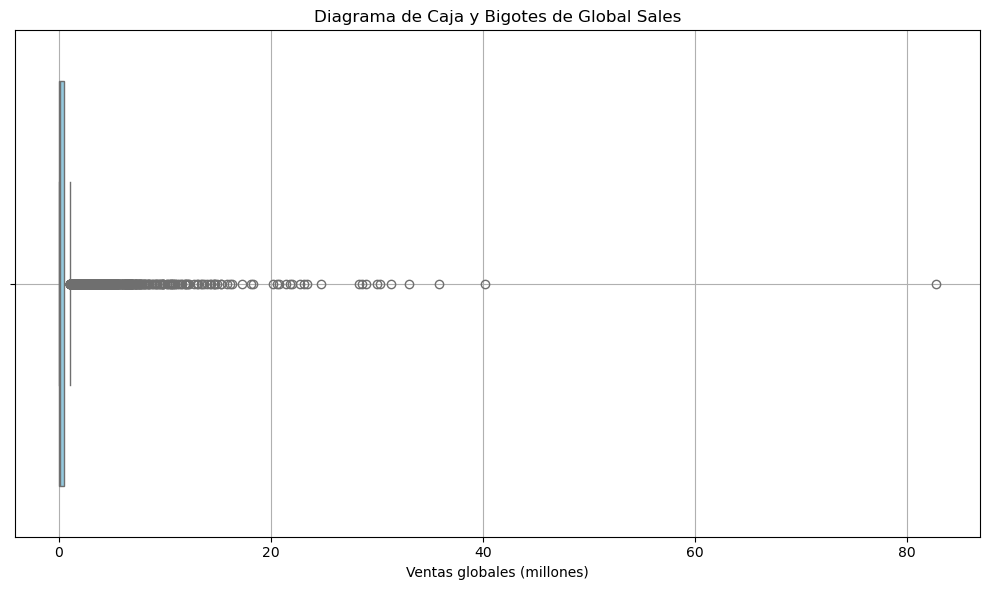

In [48]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_video_games_unido['Global_Sales'], color='skyblue')
plt.title('Diagrama de Caja y Bigotes de Global Sales')
plt.xlabel('Ventas globales (millones)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
## clasificamos las consolas en funcion de su antiguedad ##
mercado_activo = [
    'PlayStation 4','PC', 
    'Xbox One'
]
mercado_secundario = [
    'Nintendo 3DS',
    'PlayStation Vita'
]
# Función para clasificar en Actual u Obsoleta
def clasificar_consola(plataforma):
    if plataforma in mercado_activo:
        return ' Consola Activa'
    elif plataforma in mercado_secundario:
        return ' Consola Secundaria'
    else:
        return 'Obsoleta'

#Anañidos nueva columna #
df_video_games_unido['Estado_Consola'] = df_video_games_unido['Platform'].apply(clasificar_consola)

In [50]:
### añadimo la columna precios, basado en estimaciones del mercado, en momento ##
platform_prices_eur = {
    'PlayStation 4': 69.99,
    'Xbox One': 69.99,
    'PC': 49.99,
    'PlayStation 3': 59.99,
    'Xbox 360': 59.99,
    'Nintendo Wii U': 59.99,
    'Nintendo Wii': 49.99,
    'Nintendo DS': 39.99,
    'Nintendo 3DS': 39.99,
    'PlayStation 2': 49.99,
    'PlayStation Portable': 39.99,
    'Nintendo Entertainment System': 49.99,
    'Super Nintendo Entertainment System': 59.99,
    'Game Boy': 39.99,
    'PlayStation': 49.99,
    'Game Boy Advance': 39.99,
    'Nintendo 64': 59.99,
    'Xbox': 59.99,
    'Atari 2600': 29.99,
    'GameCube': 49.99,
    'Sega Genesis': 49.99,
    'Dream Cast': 49.99,
    'PlayStation Vita': 49.99,
    'Sega Saturn': 59.99,
}
def assign_launch_price(row):
    platform = row['Platform']
    return platform_prices_eur.get(platform)
df_video_games_unido['Price'] = df_video_games_unido.apply(assign_launch_price, axis=1)


In [51]:
# anañidos el precio de las consolas cuando salieron al mercado #
price_dict = {
    'Nintendo Wii': 249,
    'Nintendo Entertainment System': 199,  
    'Game Boy': 113.5,
    'Nintendo DS': 149,
    'Xbox 360': 299,
    'PlayStation 3': 599,
    'PlayStation 2': 399,
    'Super Nintendo Entertainment System': 299,
    'Game Boy Advance': 120,
    'Nintendo 3DS': 250,
    'PlayStation 4': 399,
    'Nintendo 64': 210,
    'PlayStation': 299,
    'Xbox': 299,
    'PC': 230,
    'Atari 2600': 199,
    'PlayStation Portable': 249,
    'Xbox One': 499,
    'GameCube': 199,
    'Nintendo Wii U': 299, 
    'Sega Genesis': 199,
    'Dream Cast': 240,
    'PlayStation Vita': 249,
    'Sega Saturn': 399
}
def assign_launch_price_platform(row):
    platform = row['Platform']
    return price_dict.get(platform)
df_video_games_unido['Price_Platform'] = df_video_games_unido.apply(assign_launch_price_platform, axis=1)

In [52]:
## Rellenamos los valores nulos de 'User Score' con la media en base a 'Genre' y 'Platform' ##
def imputar_user_score(row):
    if pd.isna(row['User Score']):
        media = df_video_games_unido[
            (df_video_games_unido['Platform'] == row['Platform']) &
            (df_video_games_unido['Genre'] == row['Genre'])
        ]['User Score'].mean()
        return media
    else:
        return row['User Score']
df_video_games_unido['User Score'] = df_video_games_unido.apply(imputar_user_score, axis=1)
df_video_games_unido['User Score'].fillna(df_video_games_unido['User Score'].mean(), inplace=True)


C:\Users\pablo\AppData\Local\Temp\ipykernel_22776\2351189849.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_video_games_unido['User Score'].fillna(df_video_games_unido['User Score'].mean(), inplace=True)


In [53]:
## Rellenamos los valores nulos de 'Nota PEGI' con la moda en base a 'Genre' y 'Platform' ##
def imputar_pegi(row):
    if pd.isna(row['Nota PEGI']):
        subset = df_video_games_unido[
            (df_video_games_unido['Platform'] == row['Platform']) &
            (df_video_games_unido['Genre'] == row['Genre'])
        ]['Nota PEGI']
        moda = subset.mode()
        return moda[0] if not moda.empty else np.nan
    else:
        return row['Nota PEGI']
df_video_games_unido['Nota PEGI'] = df_video_games_unido.apply(imputar_pegi, axis=1)
df_video_games_unido['Nota PEGI'].fillna(df_video_games_unido['Nota PEGI'].mode()[0],inplace=True)

C:\Users\pablo\AppData\Local\Temp\ipykernel_22776\195433462.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_video_games_unido['Nota PEGI'].fillna(df_video_games_unido['Nota PEGI'].mode()[0],inplace=True)


In [54]:
# Anadismos una columna que muestre el año de lanzamiento de la consola #
year_lanzamiento = {
    'Atari 2600': 1977, 'Nintendo DS': 2004, 'Game Boy Advance': 2001,
    'GameCube': 2001, 'Sega Genesis': 1988, 'Nintendo 64': 1996, 'Nintendo Entertainment System': 1983, 'PC': 1980,
    'PlayStation': 1994, 'PlayStation 2': 2000, 'PlayStation 3': 2006, 'PlayStation 4': 2013, 'PlayStation Portable': 2004, 
    'PlayStation Vita': 2011, 'Sega Saturn': 1994, 'Super Nintendo Entertainment System': 1990,
    'Nintendo Wii': 2006, 'Nintendo Wii U': 2012, 'Xbox 360': 2005, 'Xbox': 2001, 'Xbox One': 2013,
    'Game Boy': 1989, 'Dream Cast': 1998, 'Nintendo 3DS': 2011
}
df_video_games_unido['Year_Consola'] = df_video_games_unido['Platform'].map(year_lanzamiento)

In [55]:
print("Forma del dataframe combinado:", df_video_games_unido.shape)
print(df_video_games_unido.isnull().sum())

Forma del dataframe combinado: (16259, 19)
Name                     0
Platform                 0
Year                     0
Genre                    0
Publisher                0
NA_Sales                 0
EU_Sales                 0
JP_Sales                 0
Other_Sales              0
Global_Sales             0
Ventas_Clase             0
Nota PEGI                0
User Score               0
User Ratings Count    9894
Platforms Info        8549
Estado_Consola           0
Price                    0
Price_Platform           0
Year_Consola             0
dtype: int64


In [56]:
print(df_video_games_unido.dtypes)
print("\nEstadísticas de ventas por región y globales:")
print(df_video_games_unido[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']].describe())

Name                   object
Platform               object
Year                    int64
Genre                  object
Publisher              object
NA_Sales              float64
EU_Sales              float64
JP_Sales              float64
Other_Sales           float64
Global_Sales          float64
Ventas_Clase           object
Nota PEGI              object
User Score            float64
User Ratings Count    float64
Platforms Info         object
Estado_Consola         object
Price                 float64
Price_Platform        float64
Year_Consola            int64
dtype: object

Estadísticas de ventas por región y globales:
           NA_Sales      EU_Sales      JP_Sales   Other_Sales  Global_Sales
count  16259.000000  16259.000000  16259.000000  16259.000000  16259.000000
mean       0.266108      0.147998      0.078764      0.048518      0.541662
std        0.823139      0.509761      0.312147      0.190258      1.568751
min        0.000000      0.000000      0.000000      0.000000    

In [57]:
print("\nDimensiones del dataset:")
print(f"Filas: {df_video_games_unido.shape[0]}, Columnas: {df_video_games_unido.shape[1]}")


Dimensiones del dataset:
Filas: 16259, Columnas: 19


In [59]:
df_video_games_unido.to_csv('Data/video_games_sales_completo.csv', index=False)